In [2]:
import numpy as np
import dapper as dpr
import dapper.da_methods as da
import dapper.mods as modelling
from dapper.mods.Lorenz63 import LPs, Tplot, dstep_dx, step, x0
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

ModuleNotFoundError: No module named 'tensorflow'

In [66]:
def normalise(x, x_mean,x_std):
    return(x-x_mean)/x_std

def denormalise(x_norm,x_mean,x_std):
    return x_norm*x_std+x_mean



In [68]:

dko = 100
tseq = modelling.Chronology(0.01, dko=dko, Ko=1000, Tplot=Tplot, BurnIn=4*Tplot)
Nx = Ny = 3
Dyn = {
    'M': Nx,
    'model': step,
    'linear': dstep_dx,
    'noise': 0,
}

X0 = modelling.GaussRV(C=2, mu=x0)

jj = np.arange(Nx)  # obs_inds
Obs = modelling.partial_Id_Obs(Nx, jj)
Obs['noise'] = 2  # modelling.GaussRV(C=CovMat(2*eye(Nx)))

HMM = modelling.HiddenMarkovModel(Dyn, Obs, tseq, X0)

HMM.liveplotters = LPs(jj)


dpr.set_seed(3000)#Seed

Generator(PCG64) at 0x133237BC0

In [69]:
HMM.tseq.T = 50
xx, yy = HMM.simulate()

Truth & Obs:   0%|          | 0/5000 [00:00<?, ?it/s]

In [70]:
xp1 = da.EnKF('Sqrt', N = 500, infl = 1.02, rot = True)

xp1.assimilate(HMM,xx,yy,liveplots = False)

xp1.stats.average_in_time()

EnKF:   0%|          | 0/5000 [00:00<?, ?it/s]

In [71]:
trueVals= np.zeros((yy.shape[0],3))
counter2 = 0
counter =0;
testVals = np.zeros((dko,3))
vals = np.zeros((xp1.forecast.shape))
for x in range(xx.shape[0]):
    testVals[counter] = xx[x]
    counter = counter+1
    if ((x+1)%dko == 0):
        trueVals[counter2] = xx[x]
        counter2 = counter2+1
        break
Nx = Ny = 3

In [72]:
def F(x, sigma=10, beta=8/3, rho=28):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return np.array([dx, dy, dz])


In [73]:
x0, y0, z0 = 4.0, 10.0, 1.0
initial_conditions = np.array([x0, y0, z0])


In [74]:
Dt = 10
dt = 0.01  # Time step for generating the true trajectory
Ns = 5000 # Number of samples
Nt_shift = 10 # Number of integration time steps between samples
r = 1 # Observation stddev
# Spinup run length and data generating run length
Nt_spinup = 10000
Nt_truth = Ns*Nt_shift+Dt
x_truth = np.empty((Nt_truth,Nx))
x_truth[0] = initial_conditions
x = initial_conditions.copy()  # Initialize x with initial conditions

In [75]:
with tqdm(total=Nt_truth - 1, desc='L63 trajectory') as progress:
    for i in range(1,Nt_truth):  # Note: -1 because the initial condition is already added
        x += dt * F(x)
        x_truth[i] =x   # Append the new state to the trajectory
        progress.set_postfix_str(x, refresh=False)
        progress.update()


L63 trajectory: 100%|██████████| 50009/50009 [00:01<00:00, 39429.20it/s, [ 6.75935591 10.96555287 16.34332295]]   


In [88]:
x_perturb = x_truth + np.random.normal(loc=0, scale=r, size=(Nt_truth, Nx))#Used to introduce the trajectory of the L63 system. Does help avoid overfitting.
x_raw = x_perturb[:Nt_truth-Dt:Nt_shift]#Spaced by Nt_shift. x_perturbed has perturbed trajectory of the L63. Sampled starting from beginning and each sample is separated by a lead time of Dt 
y_raw = x_perturb[Dt:Nt_truth:Nt_shift]#Represents state of system at future points, shifted by Dt.

# Split into training and validation datasets,
# with 10% of the data being reserved for validation
index_train = np.array([i for i in range(Ns) if i%10 + 1])
index_valid = np.array([i for i in range(Ns) if not i%10])
#Use first 5000 as training and next 1000 for validation
index_train = np.array([i for i in range(Ns) if i<4000])
index_valid = np.array([i for i in range(Ns) if i>=4000 and i <5000])

#index_train = np.arange(3999)  # Create an array of indexes from 0 to 3999 (inclusive)
#index_valid = np.arange(4000, 5000) 


In [89]:
#x_train = x_raw[index_train]
#y_train = y_raw[index_train]
x_train = x_raw
y_train = y_raw
x_mean = x_train.mean(axis=0)
y_mean = y_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_std = y_train.std(axis=0)


x_train_raw_norm = normalise(x_train, x_mean,x_std)
y_train_raw_norm = normalise(y_train,y_mean,y_std)
x_train_norm = x_train_raw_norm[index_train]
y_train_norm = y_train_raw_norm[index_train]
x_valid_norm = x_train_raw_norm[index_valid]
y_valid_norm = y_train_raw_norm[index_valid]


In [90]:
initialiser = tf.keras.initializers.GlorotNormal(seed = 34)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print messages about early stopping
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

In [91]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(3,)))

model.add(tf.keras.layers.Dense(20, activation='relu', kernel_initializer=initialiser))
model.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer=initialiser))
model.add(tf.keras.layers.Dense(3, kernel_initializer=initialiser))
model.compile(optimizer='adam', loss='mse')


In [92]:
history = model.fit(
    x_train_norm, y_train_norm,
    epochs=60,
    batch_size=256,
    validation_data=(x_valid_norm, y_valid_norm),
    callbacks=[early_stopping_callback]
    #Can put where to save in early callback
)

Epoch 1/60
16/16 [==============================] - 0s 8ms/step - loss: 0.9688 - val_loss: 0.8578
Epoch 2/60
16/16 [==============================] - 0s 6ms/step - loss: 0.7521 - val_loss: 0.6821
Epoch 3/60
16/16 [==============================] - 0s 6ms/step - loss: 0.6008 - val_loss: 0.5483
Epoch 4/60
16/16 [==============================] - 0s 6ms/step - loss: 0.4819 - val_loss: 0.4355
Epoch 5/60
16/16 [==============================] - 0s 6ms/step - loss: 0.3826 - val_loss: 0.3492
Epoch 6/60
16/16 [==============================] - 0s 7ms/step - loss: 0.3127 - val_loss: 0.2912
Epoch 7/60
16/16 [==============================] - 0s 7ms/step - loss: 0.2652 - val_loss: 0.2506
Epoch 8/60
16/16 [==============================] - 0s 7ms/step - loss: 0.2313 - val_loss: 0.2201
Epoch 9/60
16/16 [==============================] - 0s 6ms/step - loss: 0.2051 - val_loss: 0.1957
Epoch 10/60
16/16 [==============================] - 0s 6ms/step - loss: 0.1839 - val_loss: 0.1756
Epoch 11/60
16/16 [

In [93]:
xVals = normalise(testVals[:-1], testVals[:-1].mean(axis=0),testVals[:-1].std(axis=0))
yVals = normalise(testVals[1:],testVals[1:].mean(axis=0),testVals[1:].std(axis=0))


In [94]:
predicted_trajectory = denormalise(model.predict(xVals), testVals[:-1].mean(axis=0),testVals[:-1].std(axis=0))
# Generate x values
x_values = np.arange(len(y_valid_norm))
x_values = np.arange(len(yVals))
updated_y = denormalise(yVals,testVals[1:].mean(axis=0),testVals[1:].std(axis=0) )
updated_y = updated_y[10:]
smallX = x_values[:-10]

4/4 [==============================] - 0s 1ms/step


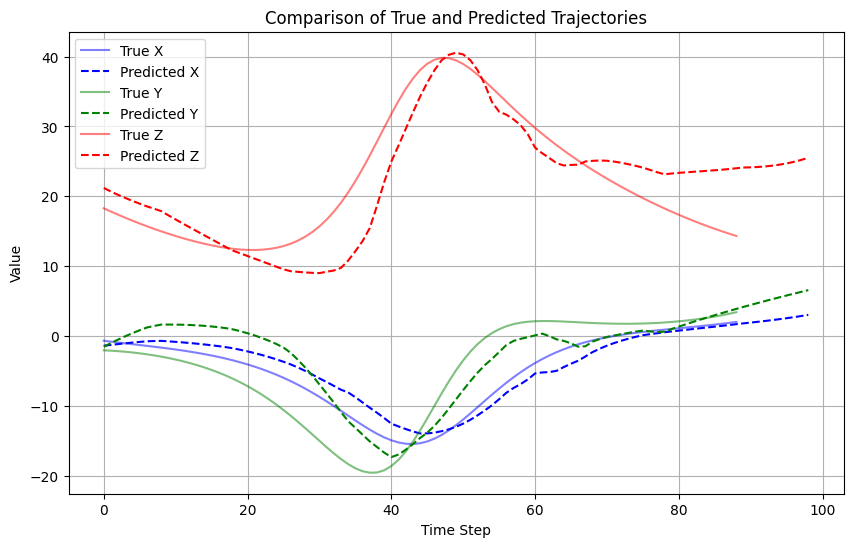

In [95]:
# Plot the true and predicted trajectories
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(smallX,updated_y[:, i], label=f'True {["X", "Y", "Z"][i]}', color=['blue', 'green', 'red'][i],alpha = 0.5)
    plt.plot(x_values, predicted_trajectory[:, i], label=f'Predicted {["X", "Y", "Z"][i]}', linestyle='--', color=['blue', 'green', 'red'][i])

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Trajectories')
plt.legend()
plt.grid(True)

plt.show()

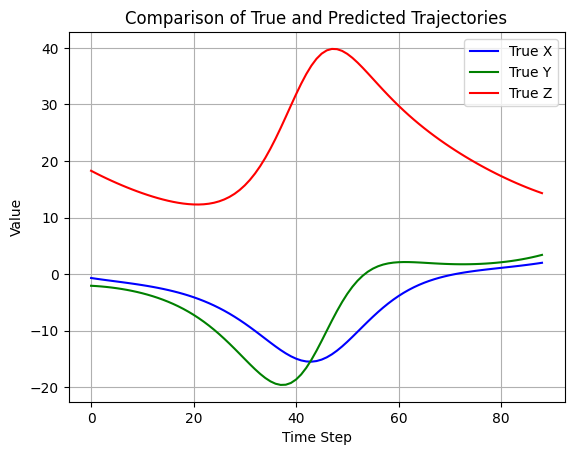

In [96]:

for i in range(3):
    plt.plot(smallX,updated_y[:, i], label=f'True {["X", "Y", "Z"][i]}', color=['blue', 'green', 'red'][i])
    #plt.plot(x_values, predicted_trajectory[:, i], label=f'Predicted {["X", "Y", "Z"][i]}', linestyle='--', color=['blue', 'green', 'red'][i])

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Trajectories')
plt.legend()
plt.grid(True)

plt.show()